In [1]:
import sys

sys.path.append("..")
sys.path.append("../../")
sys.path.append("../../src")

import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from functional_autoencoders.samplers.sampler_gmm import SamplerGMM
from functional_autoencoders.datasets import get_dataloaders
from functional_autoencoders.datasets.darcy_flow import DarcyFlow
from functional_autoencoders.util import pickle_load, get_raw_x
from plots import (
    plot_dataset_samples,
    plot_nearest_neighbours,
    set_plot_style_publication,
)

# %load_ext autoreload
# %autoreload 2

key = jax.random.PRNGKey(42)

In [2]:
MODEL_OUT_DIR = "../../tmp/experiments/sparse_training_darcy/models"
VISCOSITY = 1e-4

train_dataloader_full, test_dataloader_full = get_dataloaders(
    DarcyFlow, data_base="../..", downscale=9
)

info = pickle_load(os.path.join(MODEL_OUT_DIR, "model.pkl"))
results = info["results"]
autoencoder = info["autoencoder"]
state = results["state"]

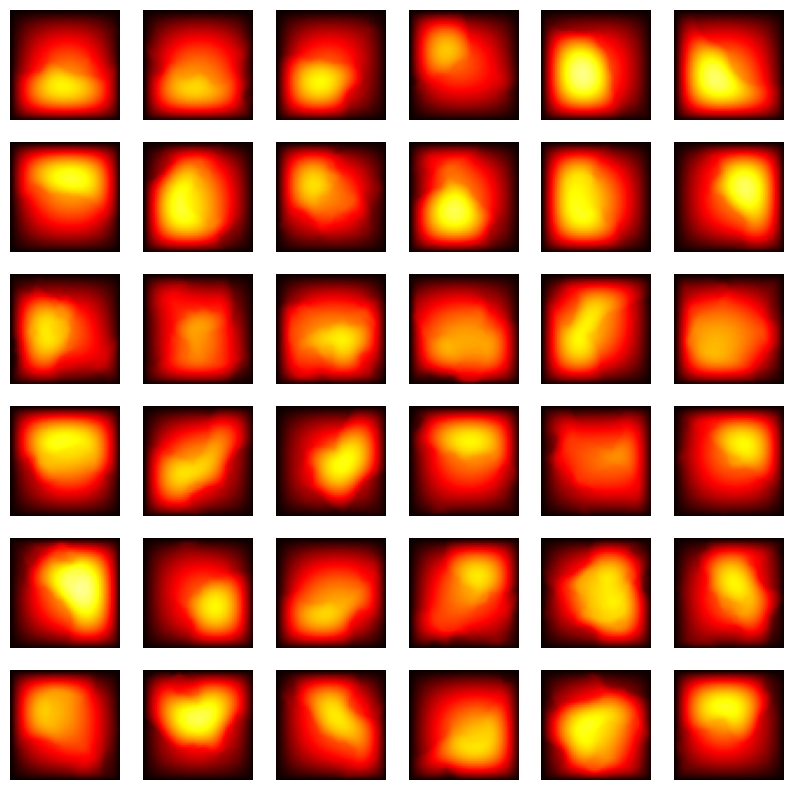

In [3]:
plt.rcParams["figure.figsize"] = (10, 10)

N_SAMPLES = 36
SUBPLOTS_PER_ROW = 6

u_list = [jnp.array(train_dataloader_full.dataset[i][0]) for i in range(N_SAMPLES)]
u_batch = jnp.stack(u_list, axis=0)

plot_dataset_samples(
    samples=u_batch,
    subplots_per_row=SUBPLOTS_PER_ROW,
)

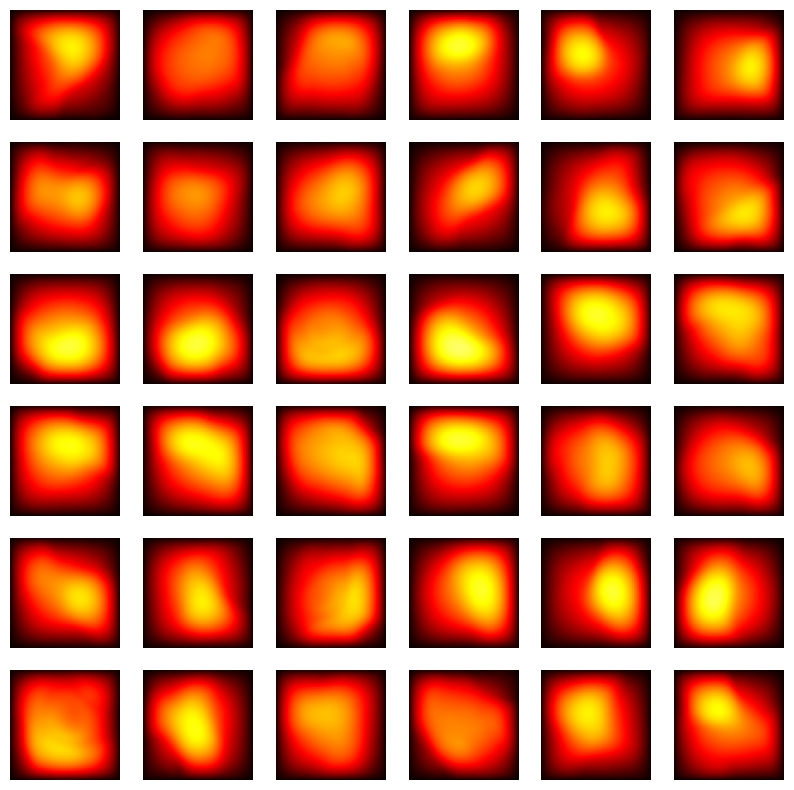

In [4]:
plt.rcParams["figure.figsize"] = (10, 10)

N_SAMPLES = 36
PTS = 64

x = get_raw_x(PTS, PTS)
x_tile = jnp.tile(jnp.expand_dims(x, 0), (N_SAMPLES, 1, 1))

sampler = SamplerGMM(autoencoder, state=results["state"], n_components=10)
sampler.fit(train_dataloader_full)
samples = sampler.sample(x_tile)

plot_dataset_samples(
    samples=samples,
    subplots_per_row=SUBPLOTS_PER_ROW,
)

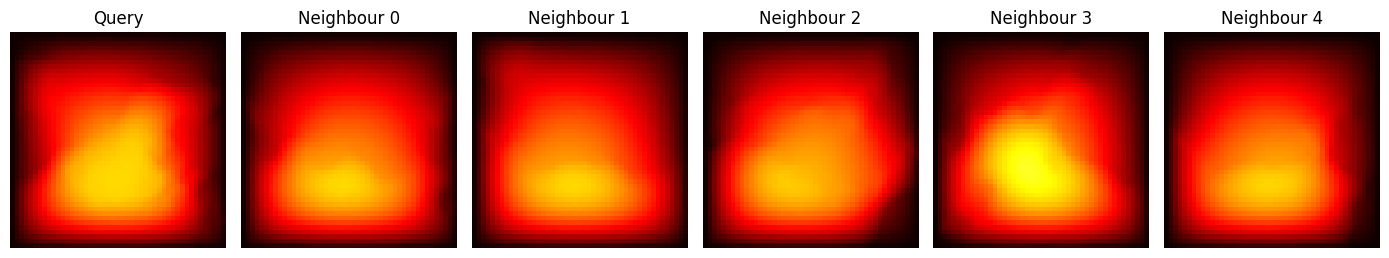

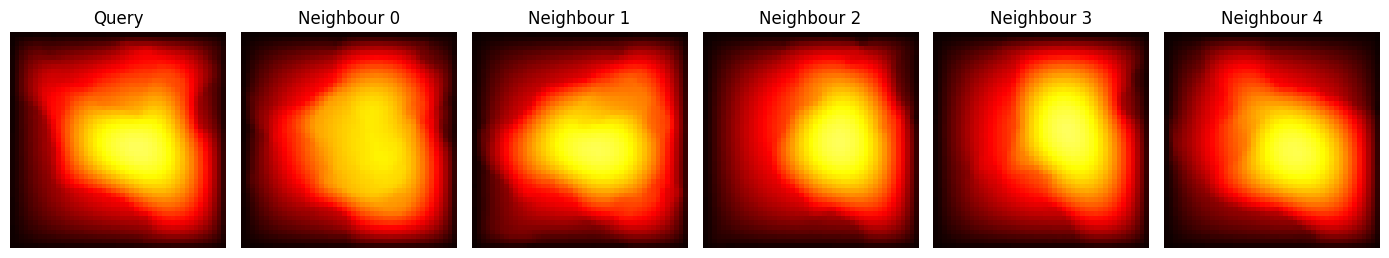

In [5]:
plt.rcParams["figure.figsize"] = (14, 5)

N_QUERIES = 2
u, _, _, _ = next(iter(test_dataloader_full))

for i in range(N_QUERIES):
    plot_nearest_neighbours(
        u=u[i],
        dataset=train_dataloader_full.dataset,
        k=5,
    )

In [6]:
SAVE_DIR = None
# SAVE_DIR = '../../figures/sparse_training/generative_samples'
# os.makedirs(SAVE_DIR, exist_ok=True)

u, x, _, _ = next(iter(test_dataloader_full))
grid_pts = int(x.shape[1] ** 0.5)
x = get_raw_x(grid_pts, grid_pts)

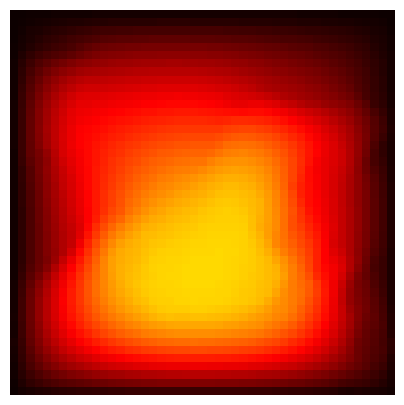

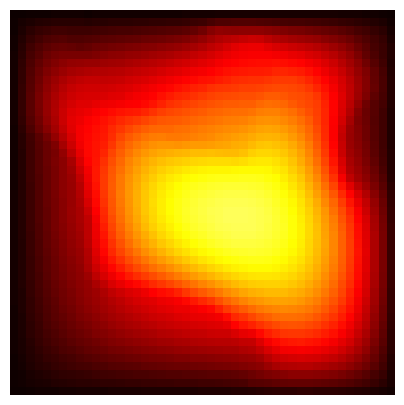

In [7]:
N_DATASET_SAMPLES = 2

for i in range(N_DATASET_SAMPLES):
    plt.imshow(u[i].reshape(grid_pts, grid_pts), cmap="hot", vmin=0, vmax=1)
    plt.axis("off")
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/original_{i}.pdf")
        plt.close()
    else:
        plt.show()

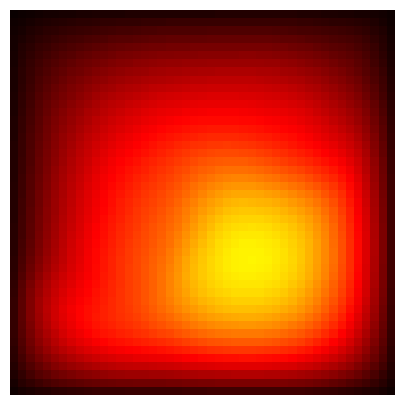

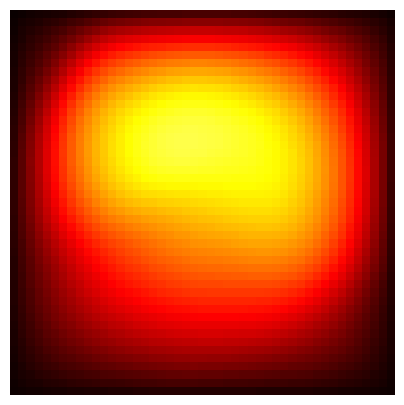

In [8]:
N_MODEL_SAMPLES = 2
N_COMPONENTS = 10

sampler = SamplerGMM(autoencoder, state=results["state"], n_components=N_COMPONENTS)
sampler.fit(train_dataloader_full)

x_tile = jnp.tile(jnp.expand_dims(x, 0), (N_MODEL_SAMPLES, 1, 1))
samples = sampler.sample(x_tile)

for i in range(N_MODEL_SAMPLES):
    plt.imshow(samples[i].reshape(grid_pts, grid_pts), cmap="hot", vmin=0, vmax=1)
    plt.axis("off")
    if SAVE_DIR is not None:
        plt.savefig(f"{SAVE_DIR}/sample_{i}.pdf")
        plt.close()
    else:
        plt.show()

In [9]:
def get_expected_max(u_samples):
    max_values = jnp.array([u_samples[i].max() for i in range(u_samples.shape[0])])
    return jnp.mean(max_values), jnp.std(max_values)


def get_expected_l2_norm(u_samples):
    l2_norms = jnp.array(
        [jnp.linalg.norm(u_samples[i]) for i in range(u_samples.shape[0])]
    )
    return jnp.mean(l2_norms), jnp.std(l2_norms)


def plot_quantities_of_interest_densities(
    ax, u_samples, dataset_samples, fn, title, has_legend=True
):
    max_values_fae = jnp.array([fn(u_samples[i]) for i in range(u_samples.shape[0])])
    max_values_dataset = jnp.array(
        [fn(dataset_samples[i]) for i in range(dataset_samples.shape[0])]
    )
    sns.kdeplot(max_values_fae, ax=ax, label="FAE", color="k", fill=True, alpha=0.5)
    sns.kdeplot(
        max_values_dataset, ax=ax, label="Ground Truth", color="r", fill=True, alpha=0.5
    )
    if has_legend:
        ax.legend()
    ax.yaxis.set_tick_params(right=False)
    ax.xaxis.set_tick_params(top=False)
    ax.set_title(title)
    ax.set_ylabel("Density")
    ax.set_xlabel(title)

In [10]:
N_MODEL_SAMPLES = len(test_dataloader_full.dataset)
N_COMPONENTS = 10

sampler = SamplerGMM(autoencoder, state=results["state"], n_components=N_COMPONENTS)
sampler.fit(train_dataloader_full)

x_tile = jnp.tile(jnp.expand_dims(x, 0), (N_MODEL_SAMPLES, 1, 1))
samples = sampler.sample(x_tile)

In [11]:
N_MODEL_SAMPLES

1024

In [12]:
expected_max, std_max = get_expected_max(samples)
expected_l2_norm, std_l2_norm = get_expected_l2_norm(samples)

print(f"Expected max (model samples): {expected_max:.2f} ± {std_max:.2f}")
print(f"Expected l2 norm (model samples): {expected_l2_norm:.2f} ± {std_l2_norm:.2f}")

Expected max (model samples): 0.74 ± 0.08
Expected l2 norm (model samples): 18.25 ± 1.52


In [13]:
expected_max, std_max = get_expected_max(test_dataloader_full.dataset.data["u"])
expected_l2_norm, std_l2_norm = get_expected_l2_norm(
    test_dataloader_full.dataset.data["u"]
)

print(f"Expected max (test dataset samples): {expected_max:.2f} ± {std_max:.2f}")
print(
    f"Expected l2 norm (test dataset samples): {expected_l2_norm:.2f} ± {std_l2_norm:.2f}"
)

Expected max (test dataset samples): 0.76 ± 0.08
Expected l2 norm (test dataset samples): 18.32 ± 1.59


In [14]:
print(f"Number of model samples: {len(samples)}")
print(f"Number of dataset samples: {len(test_dataloader_full.dataset)}")

Number of model samples: 1024
Number of dataset samples: 1024


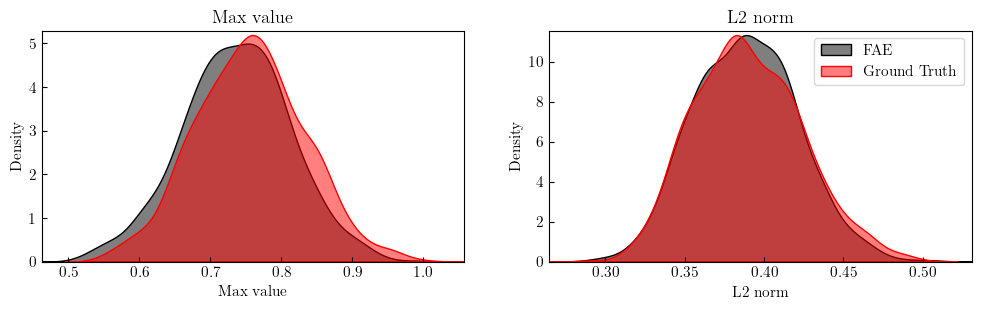

In [15]:
plt.rcParams["figure.figsize"] = (8, 4)

SAVE_DIR = None
# SAVE_DIR = '../../figures/sparse_training/samples_generation'
# os.makedirs(SAVE_DIR, exist_ok=True)

set_plot_style_publication()

max_fn = lambda u: u.max()
L2_norm_fn = (
    lambda u: (jnp.mean(jnp.sum(u**2, axis=-1), axis=range(0, u.ndim - 1))) ** 0.5
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

plot_quantities_of_interest_densities(
    ax1,
    samples,
    test_dataloader_full.dataset.data["u"],
    max_fn,
    "Max value",
    has_legend=False,
)
plot_quantities_of_interest_densities(
    ax2, samples, test_dataloader_full.dataset.data["u"], L2_norm_fn, "L2 norm"
)

if SAVE_DIR is not None:
    fig.savefig(f"{SAVE_DIR}/kde_plots.pdf")